# Changes in Hue tuning

#### This notebook compares tuning curves constructed from 5 methods:
0. Neural responses to hue images
0. Natural images
    0. Average hue in RF
    0. Linear regression on hue in RF
    0. Nonlinear regression on hue in RF
    0. From querying a successful vgg model
    
    
### Import modules and load precomputed features and processed data

In [1]:
# compute
import numpy as np
import pandas as pd
import keras

# data io
import glob
import deepdish as dd
import sys
sys.path.append('../')

# image
import cv2

# plot
import matplotlib.pyplot as plt
%matplotlib inline

# spykes
from spykes.neuropop import NeuroPop
from spykes.neurovis import NeuroVis

# stats
from scipy.stats import circmean

# machine learning
import xgboost as xgb

# local
import V4pyutils as V4

from sklearn.manifold import TSNE, MDS, SpectralEmbedding
from tqdm import tqdm
from hyperopt import fmin, hp, Trials, tpe, STATUS_OK


Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

ERROR (theano.sandbox.cuda): ERROR: Not using GPU. Initialisation of device 2 failed:
cublasCreate() returned this error 'the CUDA Runtime initialization failed'
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX TITAN X (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 5103)
/opt/anaconda/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: Th

In [2]:
h5path = '../V4pydata/H5data/M3/'
data = pd.read_excel('/home/klab/Projects/02-V4py/V4py/V4pydata/natural_artificial.xlsx')
data_M3 = data[data['Animal']=='M3']

art_df = pd.read_pickle('../02-preprocessed_data/M3/merged_art_data_across_sessions')

df_neurons = pd.read_pickle('../02-preprocessed_data/M3/data_to_combine_across_sessions')

nat_df = pd.read_pickle('../02-preprocessed_data/M3/merged_nat_data_across_sessions')

nat_features = pd.read_pickle('../02-preprocessed_data/M3/precomputed_nat_features')

### Neural responses to hue images

In [34]:
trials = Trials()

def prep_data_and_fit_neurons(df_neurons, df_data, model='XGB_poisson', session = 'art', 
                         nat_features = None, image_feature = 'hue.histogram', 
                         verbose = 0, plot=False, which_neurons = 'all',joint = False):
    """
    Fits neural data with specified model
    
    Returns a dataframe with a single column
    listing for each neuron a dictionary with 4 value/key pairs:
    'hue', 'spike_counts', 'predicted_spike_counts', 'pseudo_R2'
    
    Inputs:
    df_neurons = dataframe with neural data
    df_data = dataframe with all data. Must contain 'session_number' column
    
    Options:
    nat_features = precomputed natural features. Result of get_nat.features
                        Required when session = 'nat'.
    image_feature = {hue.histogram, hue.mean, vgg.l8, vgg.l7, vgg.l6, vgg.l5}
                        What feature to use for the natural images. 
                        Required when session = 'nat'.
                        
    model = what algorithm to feed to fit_cv 
    session = {'art', 'nat'} Which session type to fit to
    plot = {True, False} Whether to plot the fits
    verbose = {0,1,2} how much to print
    which_neurons = 'all', or list of indices of neurons to fit (in case you want just one, say)
    joint = whether to use non-images features too
    
    
    """
    assert session in ['art', 'nat']
    assert model in ['XGB_poisson', 'GLM_poisson','linear_regression','fitted_keras','art_model']
    if session is 'nat':
        assert nat_features is not None
        assert image_feature in \
             ['hue.histogram', 'hue.mean', 'vgg.l8', 'vgg.l7', 'vgg.l6', 'vgg.l5']
    if model is 'fitted_keras':
        assert image_feature in ['vgg.l8', 'vgg.l7', 'vgg.l6', 'vgg.l5'] and session is 'nat'
            
    if which_neurons is 'all':
        which_neurons = np.arange(len(df_neurons['name']))
    elif isinstance(which_neurons,int):
        which_neurons = [which_neurons]
        
    
    df_fits = pd.DataFrame(columns=[session+'_'+model+'_'+image_feature])
    which_session = session + '_sessions'
    
    # Compute feed forward features for plain hue image
    if session == 'nat':
        plain_hue = np.linspace(-np.pi, np.pi, 360)
        if image_feature in ['vgg.l8', 'vgg.l7', 'vgg.l6', 'vgg.l5']:
            
            # build model
            
            if image_feature == 'vgg.l8':
                vgg_model= V4.vgg_transfer_ari(n_pops=0)
                n_nodes = 1011
                if not joint: n_nodes = 1000
            elif image_feature == 'vgg.l7':
                vgg_model= V4.vgg_transfer_ari(n_pops=1)
                n_nodes = 4107
                if not joint: n_nodes = 4096
            elif image_feature == 'vgg.l6':
                vgg_model= V4.vgg_transfer_ari(n_pops=2)
                n_nodes = 4107
                if not joint: n_nodes = 4096
            elif image_feature == 'vgg.l5':
                vgg_model= V4.vgg_transfer_ari(n_pops=3)
                n_nodes = 25099
                if not joint: n_nodes = 25088
            
            Xplain = list()
            stimpath = '../V4pydata'
            for stim_id in range(360):
                imname = '/stimuli/M3/Hues/img%03d.jpg' % stim_id
                filename = stimpath + imname
                I = V4.load_and_preprocess_ari(filename)
                Xplain.append(np.squeeze(vgg_model.predict(I)))
            Xplain = np.array(Xplain)
            n_bins = Xplain.shape[1]
        elif image_feature == 'hue.histogram':
            # Define histograms of plain hue stimuli
            n_bins = 16
            Xplain = V4.onehothue(plain_hue, n_bins=n_bins)
        elif image_feature == 'hue.mean':
            Xplain = plain_hue.reshape((360,1))
    
    ######### Get tuning curves for all neurons ###########

    for neuron_id, neuron_name in tqdm(enumerate(df_neurons['name'])):
        
        if neuron_id not in which_neurons:
            continue

        if verbose>0:
            print 'Running neuron ' + neuron_name


        ### Get proper X and Y data ~~~~~~~~~~~~~~~

        # Extract session numbers
        sessions_of_interest = df_neurons.loc[neuron_id][which_session]

        # Grab relevant data
        if session is 'art':
            df_sessions_of_interest = df_data.loc[df_data['session.number'].isin(sessions_of_interest)]
            
            covariates =  ['predictors.hue', 
                           'predictors.col', 
                           'predictors.row', 
                           'predictors.hue_prev', 
                           'predictors.stim_dur', 
                           'predictors.off_to_onset_times']

            # Get covariates
            X = df_sessions_of_interest[covariates].values  
            # for plotting
            x_data = df_sessions_of_interest['predictors.hue'].values

            
        else:  # get natural feature
            df_sessions_of_interest = df_data.loc[df_data['session.number'].isin(sessions_of_interest) & \
                                             df_data.index.isin(nat_features['accepted_indices'])]
            #-----------------
            # Get covariates
            #-----------------
            # Select a df of interest
            indices_of_interest = np.array(df_sessions_of_interest.index)
            nat_features_of_interest = \
                nat_features.loc[nat_features['accepted_indices'].isin(indices_of_interest)]

            # Convert everything to array

            n_samples = len(nat_features_of_interest)

            # Image features
            try: n_features = len(nat_features_of_interest['image_features']\
                             [nat_features_of_interest.index[0]][image_feature])
            except TypeError: # bad practice: assuming all errors will be for same reason. 

                n_features = 1

                    
            image_features_array = np.zeros((n_samples, n_features))
            image_features_list = [nat_features_of_interest['image_features'][k][image_feature] \
                                   for k in nat_features_of_interest.index]
            for k in range(n_samples):
                image_features_array[k, :] = image_features_list[k]

            # Non-image features
            n_features = np.shape(nat_features_of_interest['non_image_features']\
                                  [nat_features_of_interest.index[0]].values)[0]
            non_image_features_array = np.zeros((n_samples, n_features))
            non_image_features_list = [nat_features_of_interest['non_image_features'][k].values \
                                   for k in nat_features_of_interest.index]
            for k in range(n_samples):
                non_image_features_array[k, :] = non_image_features_list[k]
                
            # for plotting
                            # remember we're plotting as a function of HUE MEAN
            x_data = np.array([nat_features_of_interest['image_features'][k]['hue.mean'] \
                      for k in nat_features_of_interest.index])

            # Concatenate
            if joint:
                X = np.concatenate((image_features_array, 
                                   non_image_features_array), 
                                  axis=1)
            else:
                X = image_features_array



        # Labels and number of folds for stratified CV
        labels = df_sessions_of_interest['session.number']
        n_cv = np.size(np.unique(sessions_of_interest))
        labels = [] if n_cv == 1 else labels
        n_cv = 10 if n_cv == 1 else n_cv

        # Get spike counts
        Y = df_sessions_of_interest[neuron_name].values
        
 
        
        #### Fit models ~~~~~~~~~~~~~~~~~
        my_model = None
        
        if model == 'art_model':
            # predictions from a fit tuning curve to artificial images
            from scipy.stats import binned_statistic
            def art_model(Xr,Yr,Xt,neuron_id=neuron_id,nbins=n_bins):
                assert nbins == Xr.shape[1]
                #get average spike rate in each bin
                spikes = art_XGB['art_XGB_poisson_hue.histogram'][neuron_id]['spike_counts']
                hue = art_XGB['art_XGB_poisson_hue.histogram'][neuron_id]['hue']
                bin_means, bin_edges, binnumber = binned_statistic(hue,spikes,statistic='mean',bins=nbins)

                # return lin. comb.
                return np.dot(Xt, np.reshape(bin_means,(nbins,1)))
            my_model = art_model
        
        if model is not 'fitted_keras':   
            Yt_hat, pseudo_R2 = V4.fit_cv(X, Y,
                                      stratify_by_labels=labels,
                                      n_cv=n_cv, epochs=50,batch_size=128,
                                      algorithm= model,model = my_model,
                                      verbose=verbose)
        ### Get tuning curves
        if session is 'nat' and model is not 'art_model':
            # Fit the  model
            if model == 'fitted_keras':
                model_instance = V4.keras_GLM(n_nodes, 100)
                if joint:
                    model_instance.load_weights('../02-preprocessed_data/M3/fit_models/'\
                                           +str(neuron_id)+'_'+neuron_name+'_l6_joint')
                else:
                    model_instance.load_weights('../02-preprocessed_data/M3/fit_models/'\
                                           +str(neuron_id)+'_'+neuron_name+'_l6_image')
            else:
                model_instance = V4.fit(X, Y, algorithm=model,epochs=50,batch_size=128,)
            
            ### Predict on plain hue stimuli ###
            # adding random noise to make up non-image features
            if joint:
                
                random_resample = np.random.randint(0, n_samples, Xplain.shape[0])
                Xplain_augment = np.concatenate((Xplain, 
                                      non_image_features_array[random_resample, :]), 
                                      axis=1)
            else:
                Xplain_augment = Xplain
            
                
            if model == 'XGB_poisson':
                Yplain_hat = model_instance.predict(xgb.DMatrix(Xplain_augment))
            else:
                Yplain_hat = model_instance.predict(Xplain_augment)

        
        # plot responses. for natural images, it's response to images vs. average hue of image
        if plot:
            y_data = Y
            xlabel = 'hue'
            V4.plot_xy(x_data=x_data, y_data=y_data,
                       y_model=Yt_hat,
                       lowess_frac=0.5, xlabel=xlabel, model_name=model, 
                       x_jitter_level=0., y_jitter_level=0.5, title = 'max')
            #plt.title((X[np.argmax(Yt_hat)]*180/np.pi)[0])
            #plt.ylim([0,4])
            plt.show()
            
            
        temp = dict()
        temp['hue'] = x_data
        temp['spike_counts'] = Y
        
        if model is not 'fitted_keras':
            temp['predicted_spike_counts'] = np.squeeze(Yt_hat)
            temp['pseudo_R2'] = pseudo_R2
                     
        if session is 'nat' and model is not 'art_model':
            temp['plain_hue'] = plain_hue
            temp['plain_predicted_spike_counts'] = np.squeeze(Yplain_hat)
        
        df_fits.loc[neuron_id] = [temp]
        
    return df_fits

In [35]:
art_XGB = prep_data_and_fit_neurons(df_neurons, art_df, session = 'art', model='XGB_poisson',
                          verbose = 0, plot=False, which_neurons = 'all',joint=True)

art_model_on_nat = prep_data_and_fit_neurons(df_neurons, nat_df, model='art_model', session = 'nat', 
                          nat_features = nat_features, image_feature = 'hue.histogram', 
                          verbose = 0, plot=False, which_neurons = 'all',joint=False)

90it [00:36,  4.18it/s]


In [66]:
nat_hist_glm = prep_data_and_fit_neurons(df_neurons, nat_df, model='GLM_poisson', session = 'nat', 
                          nat_features = nat_features, image_feature = 'hue.histogram', 
                          verbose = 0, plot=False, which_neurons = 'all',joint=True)

90it [16:44, 10.35s/it]


In [85]:
nat_hist_lin = prep_data_and_fit_neurons(df_neurons, nat_df, model='linear_regression', session = 'nat', 
                          nat_features = nat_features, image_feature = 'hue.histogram', 
                          verbose = 0, plot=False, which_neurons = 'all',joint=True)

90it [00:32,  4.24it/s]


In [25]:
nat_vggl6 = prep_data_and_fit_neurons(df_neurons, nat_df, model='fitted_keras', session = 'nat', 
                          nat_features = nat_features, image_feature = 'vgg.l6', 
                          verbose = 0, plot=False, which_neurons = 'all',joint=True)

90it [01:09,  1.64it/s]


In [75]:
nat_hist = prep_data_and_fit_neurons(df_neurons, nat_df, model='XGB_poisson', session = 'nat', 
                          nat_features = nat_features, image_feature = 'hue.histogram', 
                          verbose = 0, plot=False, which_neurons = 'all',joint=True)

90it [02:41,  1.32s/it]


In [80]:
nat_avg = prep_data_and_fit_neurons(df_neurons, nat_df, model='XGB_poisson', session = 'nat', 
                          nat_features = nat_features, image_feature = 'hue.mean', 
                          verbose = 0, plot=False, which_neurons = 'all',joint=True)

90it [02:02,  1.02s/it]


In [50]:
#new_results_all = pd.concat([nat_avg, nat_hist, art_XGB,nat_hist_glm, nat_hist_lin,nat_vggl6],axis=1)
new_results_all.keys()

Index([u'nat_XGB_poisson_hue.mean', u'nat_XGB_poisson_hue.histogram',
       u'art_XGB_poisson_hue.histogram', u'nat_GLM_poisson_hue.histogram',
       u'nat_linear_regression_hue.histogram', u'nat_fitted_keras_vgg.l6'],
      dtype='object')

In [52]:
new_results_all = new_results_all.merge(art_model_on_nat,left_index=True,right_index=True)

In [58]:
#trials.best_trial
# {'dropout': [0],
#    'hidden_dim': [50],
#    'l1l2': [0.0011088222637138541],
#    'lr': [0.00016694354729608157]}

In [4]:
results_all = pd.read_pickle('../02-preprocessed_data/M3/results_all')

In [5]:
#new_results_all.to_pickle('results_all_ari')
new_results_all = pd.read_pickle('results_all_ari')

### Build a model that fits all neurons at once, sharing one layer of the dense net

In [127]:
new_results_all.keys()

Index([u'nat_XGB_poisson_hue.mean', u'nat_XGB_poisson_hue.histogram',
       u'art_XGB_poisson_hue.histogram', u'nat_GLM_poisson_hue.histogram',
       u'nat_linear_regression_hue.histogram', u'nat_fitted_keras_vgg.l6',
       u'nat_art_model_hue.histogram'],
      dtype='object')

### Visualize pR2 of results

In [121]:

import mpl_toolkits.axes_grid.inset_locator as il

def bootstrap(yy):
    # sample with replacement
    means = []
    N = 1000
    for i in range(N):
        yy_samp = np.random.choice(yy,len(yy))
        means.append(np.mean(yy_samp))
    means = np.sort(means)
    crit05 = int(0.025*N)
    crit95 = int(0.975*N)
    return np.abs(np.mean(yy)-means[[crit05,crit95]])

colors=['#F5A21E', '#EF3E34', '#134B64', '#FF07CD']


def plot_scatter(model_names, ax_ran=[0, 0.2, 0, 0.2],ts=16,labels = None):
    """Plots scores as a scatter plot with an inset of the population mean.
    
    model_names = list of strings of the methods to plot. First in the list is the x-axis, rest are scatter.
                The strings should be keys in the dataframe `models`.
    ax_ran = the plotting range. Given to plt.axis
    ts = label size
    models = dataframe that contains results of methods. Each 'result' is a dictionary with
                keys 'PR2' and 'Yt_hat'
    labels = list of labels for inset bar chart. Defaults to the keys of the dictionary. """
    
    if labels is None:
        labels = model_names
    
    first = model_names[0]
    sn = np.sqrt(90)
    xx = np.array([np.mean(new_results_all[first][i]['pseudo_R2']) for i in range(90)])
    xerr = np.array([np.std(new_results_all[first][i]['pseudo_R2']) for i in range(90)])/sn
    alpha_lines = 0.3
    alpha = 1
    lim = ax_ran[1]
    j=0
    p = []
    
    means=[np.mean(xx)]
    mean_err = bootstrap(xx)
    
    for mod in model_names[1:]:
        yy = np.array([np.mean(new_results_all[mod][i]['pseudo_R2']) for i in range(90)])
        yerr = np.array([np.std(new_results_all[first][i]['pseudo_R2']) for i in range(90)])/sn
       
        ## uncomment to plot error
        #p1,c,b=plt.errorbar(xx, yy,fmt=marks[i], xerr = xerr, yerr = yerr ,ms=msize[i], alpha=1,color=colors[i+1])
        p1,=plt.plot(xx, yy, '.', ms=10, alpha=.5,color='k')
        
        p.append(p1)
        plt.plot([-lim, lim], [-lim, lim], 'k:', lw=1, alpha=alpha_lines)
        
        j+=1
        
        means.append(np.mean(yy))
        mean_err = np.vstack((mean_err,bootstrap(yy)))

        
    ax = plt.gca()
    V4.simpleaxis(ax)

    plt.xlabel('Artificial Tuning pseudo-$R^2$',fontsize=ts)
    plt.ylabel('Natural Tuning pseudo-$R^2$',fontsize=ts)
    plt.axis(ax_ran)
            
    ax.set_yticks([0], minor=True)
    ax.set_xticks([0], minor=True)
    plt.grid(which='minor')
    
    # insert bar chart that is the average
    
    freq = np.round((np.max(means)-np.min(means))/5,2)
    if freq<0.01:
        freq = np.round(np.max(means)/5,3)

    
    inset_axes = il.inset_axes(ax, 
                    width="30%", # width = 34% of parent_bbox
                    height="70%", # height : 1 inch
                    loc=7, borderpad = 1.5,
                    axes_kwargs = {'title':'Mean p$R^2$',
                                  'yticks':np.arange(-.6,np.max(means)*1.5,freq),
                                   'ylim':[np.min(means)*1.1,np.max(means)*1.5] })
    

    plt.bar(np.arange(np.size(means)), means, 0.6, align='center',
            ecolor='k', alpha=.9, color=colors, ec='w',yerr = mean_err.transpose(),
            tick_label=labels)
    plt.plot([-.6,len(labels)-.6],[0,0],color='black',)

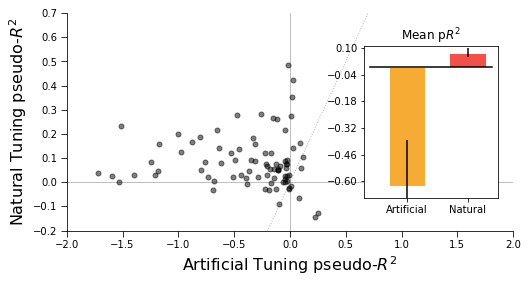

In [122]:
plt.figure(figsize=(8,4))
plot_scatter(['nat_art_model_hue.histogram','art_XGB_poisson_hue.histogram'],
            ax_ran= [-2,2,-.2,.7],labels = ['Artificial','Natural', ])

### Build the various tuning curves

In [248]:

def plot_fits(neuron_id):
    plt.figure(figsize=(4,4))
    neuron_name = df_neurons['name'][neuron_id]

    plot_xy(new_results_all['art_XGB_poisson_hue.histogram'][neuron_id]['hue'], 
            new_results_all['art_XGB_poisson_hue.histogram'][neuron_id]['spike_counts'],plot_points=False,colors=['k'],
           labels = ['Single hue response'])

    y_datas = [new_results_all[model_][neuron_id]['plain_predicted_spike_counts'] for model_ in\
              [ u'nat_XGB_poisson_hue.histogram',
               u'nat_linear_regression_hue.histogram',
               ]]

    plot_xy(new_results_all['nat_XGB_poisson_hue.mean'][neuron_id]['plain_hue'], 
            y_datas,xlabel='Hue',labels=['Nonlinear model','Linear model'],lw = 2,)#colors=['r','b'])
    #plt.title(str(neuron_id)+' '+neuron_name)
    plt.savefig('../05-figures_CCN/neuron-fit_{}.pdf'.format(str(neuron_id)), format='pdf')
    nat_predictions_1 = np.squeeze(new_results_all['nat_linear_regression_hue.histogram']\
                                   [neuron_id]['plain_predicted_spike_counts'])
    nat_predictions_2 = np.squeeze(new_results_all['nat_XGB_poisson_hue.histogram']\
                                   [neuron_id]['plain_predicted_spike_counts'])

    print 'Linear/ XGB_hist corr coeff: {}'.format(np.corrcoef(nat_predictions_1, nat_predictions_2)[0,1])
    print 'XGB pR2: {}. Linear pR2: {}'.format(np.mean(new_results_all['nat_XGB_poisson_hue.histogram']\
                                   [neuron_id]['pseudo_R2']), np.mean(new_results_all['nat_linear_regression_hue.histogram']\
                                   [neuron_id]['pseudo_R2']))
    #plt.ylim([0,5])
    plt.xlabel('Hue',fontsize=18)
    plt.xticks(fontsize= 14)
    plt.yticks(fontsize= 14)
    plt.show()


Linear/ XGB_hist corr coeff: 0.144606835169
XGB pR2: 0.0350670560908. Linear pR2: -0.0996023217735


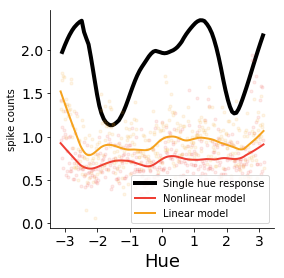

Linear/ XGB_hist corr coeff: 0.429443255588
XGB pR2: -0.0477089335992. Linear pR2: -3.94312552708


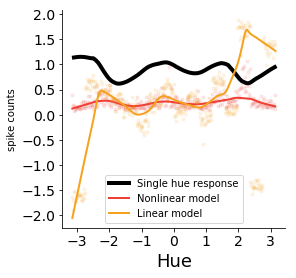

Linear/ XGB_hist corr coeff: 0.293997775622
XGB pR2: 0.0827639879322. Linear pR2: -0.261460550192


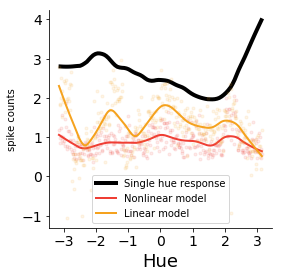

Linear/ XGB_hist corr coeff: 0.311444884068
XGB pR2: 0.0430288850599. Linear pR2: -0.0148544697617


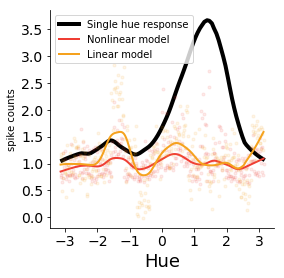

Linear/ XGB_hist corr coeff: 0.393056077347
XGB pR2: 0.0333084807834. Linear pR2: -0.022458458409


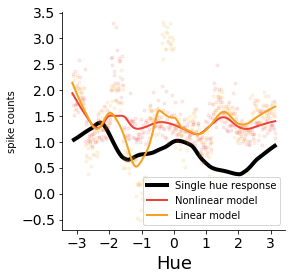

In [249]:
for i in range(15,20):
    plot_fits(i)

# Get correlation of tuning curves with artificial (fitted) tuning curves

In [166]:
nat_models = new_results_all.drop(['art_XGB_poisson_hue.histogram'],axis=1).columns  
nat_models = [ u'nat_XGB_poisson_hue.histogram',
       u'nat_linear_regression_hue.histogram',
      ]

art_model_name = 'art_XGB_poisson_hue.histogram'

art_nat_corrs = dict()
for nat_model in nat_models:
    print nat_model
    art_nat_corrs[nat_model] = list()
    for neuron_id, neuron_name in enumerate(df_neurons['name']):

            # Fit a polynomial to the art tuning curve
        h = new_results_all[art_model_name][neuron_id]['hue'] * 180. / np.pi
        h[h < 0.] = 360. + h[h < 0.]

        f_poly = np.poly1d(np.polyfit(h, new_results_all[art_model_name][neuron_id]['predicted_spike_counts'], 5))        
        art_plain_hue = f_poly(new_results_all[nat_model][neuron_id]['plain_hue'])

        nat_predictions = np.squeeze(new_results_all[nat_model][neuron_id]['plain_predicted_spike_counts'])

        this_art_nat_corr = np.corrcoef(art_plain_hue, nat_predictions)[0,1]
        art_nat_corrs[nat_model].append(this_art_nat_corr)

nat_XGB_poisson_hue.histogram
nat_linear_regression_hue.histogram


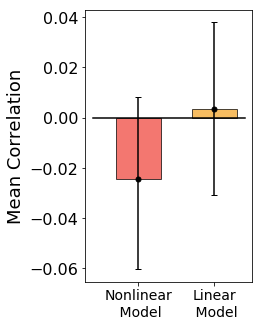

In [245]:
colors=['#EF3E34', '#F5A21E', '#134B64',  '#02A68E', '#FF07CD']
plt.figure(figsize=(3,5))

means = [np.mean(art_nat_corrs[nat_model]) for nat_model in nat_models]
mean_err = np.array([bootstrap(art_nat_corrs[nat_model]) for nat_model in nat_models])
labels = ['Nonlinear\n Model','Linear\n Model',]

plt.bar(np.arange(np.size(means)), means, 0.6, align='center',
            ecolor='k', alpha=.7, color=colors, ec='k',
            tick_label=labels,)

(_, caps, _) = plt.errorbar(np.arange(np.size(means)), means,c='k', yerr = mean_err.transpose(),
         marker='.',ecolor='k',capsize=3, ms=10,elinewidth=1.5, lw=0)

plt.ylabel('Mean Correlation',fontsize=18)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 16)
plt.plot([-.6,len(labels)-.6],[0,0],color='black',)
plt.savefig('../05-figures_CCN/hue_tune_corr_bar.pdf', format='pdf')
plt.show()

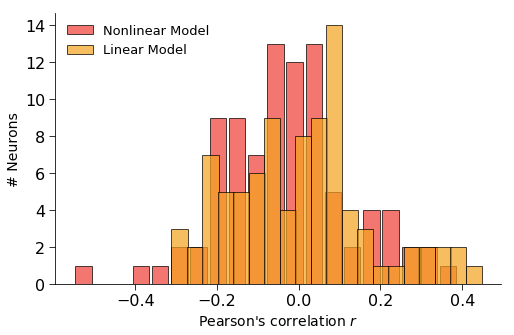

In [244]:
plt.figure(figsize=(8,5))
ax = plt.subplot(111)
#colors = ['r','b','y','k']

for i,nat_model in enumerate(nat_models):
    x = np.array(art_nat_corrs[nat_model])
    ax.hist(x[~np.isnan(x)], 20, color=colors[i], alpha=0.7, edgecolor = 'k',width = .04)
    
    # ax.hist(art_syn2_corr, 20, color='r', alpha=0.2)
    # ax.hist(art_syn3_corr, 20, color='b', alpha=0.2)
    # ax.hist(art_syn4_corr, 20, color='y', alpha=0.2)
plt.legend(['Nonlinear Model','Linear Model',], loc='upper left', frameon=False, fontsize = 13)
plt.xticks(fontsize= 16)
plt.yticks(fontsize= 16)
plt.xlabel('Pearson\'s correlation $r$', fontsize=14)
plt.ylabel('# Neurons', fontsize=14)
V4.simpleaxis(ax)
#ax.plot(np.arange(60), np.zeros(60), 'k--')
#plt.xlim([-1, 60])
#plt.xlabel('neuron', fontsize=14)
plt.savefig('../05-figures_CCN/hue_tune_corr_histogram.pdf', format='pdf')
plt.show()

Whereas the correlations among the models:

In [107]:
x.shape

(90,)

nat_XGB_poisson_hue.mean___nat_XGB_poisson_hue.histogram
Mean 0.08 ± 0.02
nat_XGB_poisson_hue.mean___nat_GLM_poisson_hue.histogram
Mean nan ± nan
nat_XGB_poisson_hue.mean___nat_linear_regression_hue.histogram
Mean 0.10 ± 0.02
nat_XGB_poisson_hue.mean___nat_fitted_keras_vgg.l6
Mean 0.03 ± 0.02
nat_XGB_poisson_hue.histogram___nat_GLM_poisson_hue.histogram
Mean nan ± nan
nat_XGB_poisson_hue.histogram___nat_linear_regression_hue.histogram
Mean 0.33 ± 0.03
nat_XGB_poisson_hue.histogram___nat_fitted_keras_vgg.l6
Mean 0.05 ± 0.02


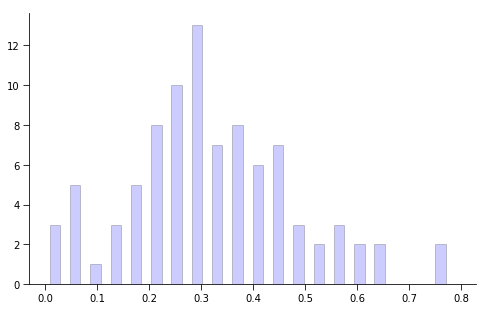

In [159]:
plt.figure(figsize=(8,5))
ax = plt.subplot(111)

nat_nat_corrs = dict()
i=0
for j,nat_model_1 in enumerate(nat_models):
    if j>1:
        continue
    for nat_model_2 in nat_models[(j+1):]:
        nat_nat_corrs[nat_model_1 + '_' + nat_model_2] = list()
        for neuron_id, neuron_name in enumerate(df_neurons['name']):
            nat_predictions_1 = np.squeeze(new_results_all[nat_model_1][neuron_id]['plain_predicted_spike_counts'])
            nat_predictions_2 = np.squeeze(new_results_all[nat_model_2][neuron_id]['plain_predicted_spike_counts'])
            
            this_nat_nat_corr = np.corrcoef(nat_predictions_1, nat_predictions_2)[0,1]
            nat_nat_corrs[nat_model_1 + '_' + nat_model_2].append(this_nat_nat_corr)
            
        print nat_model_1 + '___' + nat_model_2
        print 'Mean {0:0.2f} ± {1:0.2f}'.format(np.mean(np.array(nat_nat_corrs[nat_model_1 + '_' + nat_model_2])), \
                2*np.std(np.array(nat_nat_corrs[nat_model_1 + '_' + nat_model_2]))/np.sqrt(90))
        
        i+=1
        
nat_model_2 = 'nat_linear_regression_hue.histogram'
nat_model_1 = 'nat_XGB_poisson_hue.histogram'
x = np.array(nat_nat_corrs[nat_model_1 + '_' + nat_model_2])
ax.hist(x[~np.isnan(x)], 20, color='b', alpha=0.2, edgecolor = 'k',width = .02)

V4.simpleaxis(ax)     
plt.show()

### Run same analysis for orientation

In [ ]:
ori_df = pd.read_pickle('../02-preprocessed_data/M3/merged_art_data_across_sessions_orientation')
# Correct for orientation angle > 180 deg.
ori_df['predictors.ori'] = np.where(ori_df['predictors.ori'] >= 180.0,
                                ori_df['predictors.ori'] - 180.0,
                                ori_df['predictors.ori'])
ori_df['predictors.ori_prev'] = np.where(ori_df['predictors.ori_prev'] >= 180.0,
                                     ori_df['predictors.ori_prev'] - 180.0,
                                     ori_df['predictors.ori_prev'])

In [ ]:
plt.figure(figsize=(12,5))

# L6
ax = plt.subplot(121)
V4.simpleaxis(ax)

syn_model1_name = 'vggl6_model'
for neuron_id, neuron_name in enumerate(df_results_all['name']):
    mu_x = np.mean(nat_hue_hist[neuron_id]['pseudo_R2'])
    sigma_x = np.std(nat_hue_hist[neuron_id]['pseudo_R2'])
    
    mu_y = np.mean(nat_100l_glm[neuron_id]['pseudo_R2'])
    sigma_y = np.std(nat_100l_glm[neuron_id]['pseudo_R2'])
    
    if (mu_y - 2. * sigma_y > 0.):
        ax.errorbar(x=mu_x, y=mu_y, 
                    xerr=sigma_x, yerr=sigma_y,
                    fmt='ko', alpha=0.2)

ax.plot(np.linspace(-2., 2., 10), np.linspace(-2., 2., 10), 'k--')
ax.plot(np.linspace(-2., 2., 10), 2. * np.linspace(-2., 2., 10), 'k--')
ax.plot(np.linspace(-2., 2., 10), 5. * np.linspace(-2., 2., 10), 'k--')
ax.plot(np.linspace(-2., 2., 10), np.zeros(10), 'k--')
ax.plot(np.zeros(10), np.linspace(-2., 2., 10), 'k--')
ax.axis([-0.2, 1.2, -0.2, 1.2])
plt.xlabel('histogram [pseudo-$R^2$]', fontsize=12)
plt.ylabel('VGG16 L6 [pseudo-$R^2$]', fontsize=12)

In [240]:

def plot_xy(x_data=None, y_datas=None, 
            lowess_frac = 0.2,
            xlabel='variable',
            model_name='hue',
            x_jitter_level=0, y_jitter_level=0.5,
            semilogx=False,
            model_alpha=0.1,lw=4,
            colors=['#EF3E34', '#F5A21E', '#134B64',  '#02A68E', '#FF07CD'],
            data_ms = 10, title = None, labels = None,
            plot_points=True):
    
    if not isinstance(y_datas,list):
        y_datas = [y_datas]
    
    if labels is None:
        labels = ['_']*len(y_datas)

    # User lowess smoothing to smooth data and model
    lowess = V4.sm.nonparametric.lowess
    smoothed_data = [lowess(np.squeeze(y_d), x_data, frac=lowess_frac) for y_d in y_datas]

    # Add jitter to both axes
    x_jitter = x_jitter_level * np.random.rand(np.size(x_data))
    y_jitter = y_jitter_level * np.random.rand(np.size(y_datas[0]))

    # Display
    if semilogx:
        for i,y_data in enumerate(y_datas):
            if plot_points:
                plt.semilogx(x_data + x_jitter,
                         y_data + y_jitter,
                         '.', alpha=model_alpha, color = colors[i],
                         ms=data_ms)

       

            plt.semilogx(smoothed_data[i][:, 0],
                         smoothed_data[i][:, 1],
                         color=colors[i], lw=4)


    else:
        for i,y_data in enumerate(y_datas):
            if plot_points:
                plt.plot(x_data + x_jitter,
                     y_data,
                     '.', color=colors[i],
                     alpha=model_alpha,label='_')


            plt.plot(smoothed_data[i][:,0],
                     smoothed_data[i][:,1],
                     color=colors[i], lw=lw,label=labels[i])

    ax=plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tick_params(axis='y', right='off')
    plt.tick_params(axis='x', top='off')
    plt.xlabel(xlabel)
    plt.ylabel('spike counts')
    #plt.legend(['data', 'model %s' % model_name, 'smoothed data', 'smoothed model'],
    #           frameon=False)
    
    if title == 'max':
        model_max = smoothed_data[np.argmax(smoothed_model[:,1]),0]
        data_max = smoothed_data[np.argmax(smoothed_data[:,1]),0]
        title = 'Model {0:.2f} ; Data {1:.2f}'.format(model_max,data_max)
    
        plt.title(title)
        
    plt.legend()

In [ ]:
       
        ### Hyperparameter optimization
        
#         space4rf = {
#             'learning_rate': hp.loguniform('lr', np.log(1e-5), np.log(1e-2)),
#             'l1l2': hp.loguniform('l1l2', np.log(1e-3),np.log(1e-1)),
#             'hidden_dim': hp.choice('hidden_dim', list(np.arange(100))),
#             'dropout': hp.choice('dropout' , [0.1,0.2,0.3,0.4,0.5]),
#         }

        
        
#         def keras_GLM( hidden_dim, learning_rate=0.0001,l1l2 = 0.01,dropout = 0.5):
#             model = keras.models.Sequential()
#             input_dim = X.shape[1]
#             # Add a dense exponential layer with hidden_dim outputs
#             if hidden_dim > 0:
#                 model.add(keras.layers.Dense(hidden_dim, input_shape=(input_dim,), \
#                                 kernel_initializer='glorot_normal', activation='relu'))
#                 model.add(keras.layers.Dropout(dropout))

#                 # Add a dense exponential layer with 1 output
#                 model.add(keras.layers.Dense(1, kernel_initializer='glorot_normal', activation='softplus', \
#                                 activity_regularizer=keras.regularizers.l1_l2(l1l2)))

#             else:
#                 # Add a dense exponential layer with 1 output
#                 model.add(keras.layers.Dense(1, input_shape=(input_dim,),\
#                                 kernel_initializer='glorot_normal', activation='softplus', \
#                                 activity_regularizer=keras.regularizers.l1_l2(l1l2)))

#             optim = keras.optimizers.Nadam(lr=learning_rate, clipnorm=0.5)

#             model.compile(loss='poisson', optimizer=optim)
#             return model
#         def fnc(params):
            
#             my_model = keras_GLM(**params)
            
#             Yt_hat, pseudo_R2 = V4.fit_cv(X, Y,
#                                       stratify_by_labels=labels,
#                                       n_cv=n_cv, epochs=50,batch_size=128,
#                                       algorithm= model,model = my_model,
#                                       verbose=1)
            
#             return -np.mean(pseudo_R2)

#         hyperoptBest = fmin(fnc, space4rf, algo=tpe.suggest, max_evals=100, trials=trials)

### Check if mean hue is calculated right

### Rigorously characterize the response to flat hue == model fit to neural response to flat hue

NameError: name 'df' is not defined

## Image clustering

First just by kmeans on the vggl6 activations

In [4]:
num_images = nat_features['image_features'].shape[0]
X = np.array([nat_features['image_features'][i]['vgg.l7'] for i in range(num_images)])

In [5]:
X.shape

(32994, 4096)

[0.0, 23.9985294342041, 24.838476181030273, 25.97393226623535, 31.67388916015625, 32.096500396728516, 32.791221618652344, 33.14191436767578, 34.55217361450195, 34.71451950073242, 34.93434524536133, 35.7611083984375, 36.4197998046875, 36.68812561035156, 36.80003356933594, 38.0250244140625, 38.48384475708008, 39.114688873291016, 39.16889953613281, 39.17019271850586, 39.22370910644531, 39.57767105102539, 39.786014556884766, 39.9533576965332, 40.06804275512695, 41.01043701171875, 41.07821273803711, 41.81227493286133, 42.65007019042969, 43.26443862915039, 43.28410720825195, 43.32867431640625, 43.333065032958984, 44.09722137451172, 44.102054595947266, 44.427818298339844, 44.530967712402344, 44.582359313964844, 44.587501525878906, 44.6143798828125, 44.810997009277344, 45.1081428527832, 45.270263671875, 45.40521240234375, 45.53768539428711, 45.746315002441406, 45.777286529541016, 45.793704986572266, 45.79403305053711, 45.813438415527344]


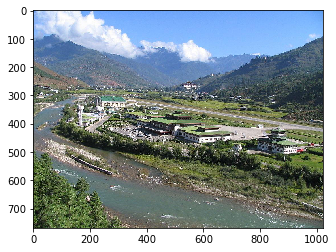

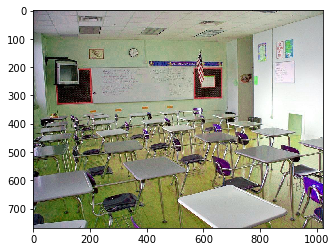

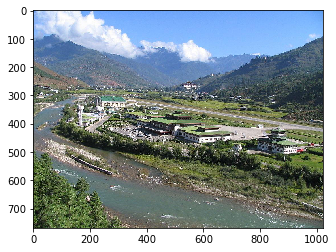

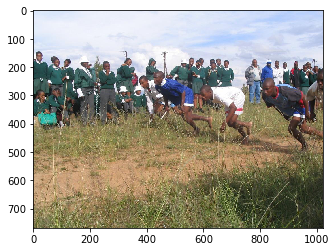

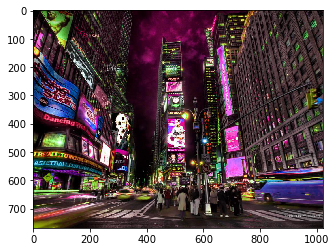

In [7]:
from scipy.spatial.distance import euclidean as dist_meas
from sklearn.neighbors import NearestNeighbors

### look for standard distance values
X_test = X[1000,:]
dists = []
for i in range(X.shape[0]):
    dists.append(dist_meas(X_test, X[i,:]))
#plt.hist(dists,bins=100)
print sorted(dists)[:50]

for i in np.argsort(dists)[:5]:
    plt.imshow(
            V4.get_image('../V4pydata', nat_df.loc[i]['im.path'] , nat_df.loc[i]['im.name']))

    plt.show()


In [ ]:
# now build similarity matrix
neigh = NearestNeighbors(n_neighbors=5, radius=40.0, 
                         algorithm='auto', leaf_size=30, metric='minkowski', p=2, metric_params=None, n_jobs=-1)
neigh.fit(X) 
A = neigh.radius_neighbors_graph(X)

In [10]:
A

<32994x32994 sparse matrix of type '<type 'numpy.float64'>'
	with 33040 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.cluster import DBSCAN

sc = DBSCAN(eps=40, min_samples=5, metric='euclidean', algorithm='auto', leaf_size=30, p=None, n_jobs=-1)

#sc.fit(X)
labels = sc.fit_predict(X)

(array([  3.29640000e+04,   2.00000000e+00,   4.00000000e+00,
          0.00000000e+00,   6.00000000e+00,   6.00000000e+00,
          0.00000000e+00,   6.00000000e+00,   4.00000000e+00,
          2.00000000e+00]),
 array([ 0. ,  0.7,  1.4,  2.1,  2.8,  3.5,  4.2,  4.9,  5.6,  6.3,  7. ]),
 <a list of 10 Patch objects>)

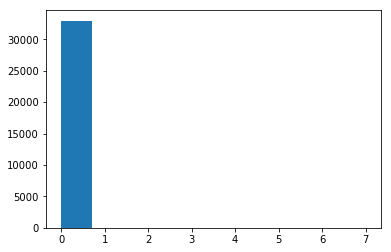

In [69]:
plt.hist(labels)

In [50]:
import imagehash
from PIL import Image
import six

def find_similar_images(userpath, hashfunc = imagehash.phash):
    """Or phash, whash, dhash"""
    import os
    def is_image(filename):
        f = filename.lower()
        return f.endswith(".png") or f.endswith(".jpg") or \
            f.endswith(".jpeg") or f.endswith(".bmp") or f.endswith(".gif")
    
    image_filenames = [os.path.join(userpath, path) for path in os.listdir(userpath) if is_image(path)]
    images = {}
    for img in sorted(image_filenames):
        hash = hashfunc(Image.open(img))
        images[hash] = images.get(hash, []) + [img]
    return images

def print_same_hash(im_hash):
    for k, img_list in six.iteritems(im_hash):
        if len(img_list) > 1:
            print k
            print(" ".join(img_list))

In [48]:
im = '../V4pydata/' + nat_df.loc[0]['im.path'] + '/' 
im_hash = find_similar_images(im)

from scipy.spatial.distance import hammard as dist_meas

### look for standard distance values
X_test = im_hash[1000,:]
dists = []
for i in range(im_hash.shape[0]):
    dists.append(dist_meas(X_test, X[i,:]))
#plt.hist(dists,bins=100)
print sorted(dists)[:10]

for i in np.argsort(dists)[:10]:
    I = cv2.imread(filename)
    if I is not None:
        I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
    I
    
    return Iplt.imshow(
            V4.get_image('../V4pydata', nat_df.loc[i]['im.path'] , nat_df.loc[i]['im.name']))

    plt.show()


In [119]:
np.array(str(im_hash.keys()[i]))

array('9b29e993e4165473', 
      dtype='|S16')

### Things to cluster by

in images where the hue is nearly even, is there a difference there? would be evidence of top down or attentional effects